In [81]:
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.types import Command, interrupt
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
import uuid
from langchain_core.messages import HumanMessage
from IPython.display import Image, display

In [82]:
llm=ChatGroq(model="llama-3.1-8b-instant")

In [105]:
persistent_state={}

In [106]:
class State(TypedDict):
    linkedin_topic: str
    generated_post: Annotated[List[str], add_messages]
    human_feedback: Annotated[List[str], add_messages]

In [107]:
def model(state: State):
    """
        Here, we're using the LLM to generate a LinkedIn Post with human feedback incorporated
    """
    
    # print("[model] Generating content")
    linkedin_topic=state['linkedin_topic']
    feedback= state['human_feedback'][-1].content if state['human_feedback'] else "No Feedback Yet"

    # Here we define the prompt
    prompt=f"""

    LinkedIn Topic: {linkedin_topic}
    Human Feedback: {feedback}

    Generate a structured and well written LinkedIn post based on the given topic

    Consider previous human feedback to refine the response
    """
    response=llm.invoke(input=[
        SystemMessage(content="You are an expert LinkedIn content writer"),
        HumanMessage(content=prompt)
    ])

    generated_linkedin_post=response.content

    # print(f"Model Node generated post:\n {generated_linkedin_post}")

    state['generated_post']=[AIMessage(content=generated_linkedin_post)]
    # state['human_feedback']=[AIMessage(content=feedback)]
    
    model_payload={
        "generated_post": [AIMessage(content=generated_linkedin_post)],
        "human_feedback": [feedback]
    }
    # print(f"Present State: {model_payload}\n")
    persistent_state['state']=state
    return state

    

In [108]:
def human_node(state:State):
    """
        Human Intervention node - loops back to model unless input is done
    """
    # print("\n [human_node] awaiting human feedback...")
    generated_post=state["generated_post"][-1]
    
    # Interrupt to get user feedback
    user_feedback=interrupt(
        value={
            "generated_post":generated_post,
            "message":"Provide feedback or type 'done' to finish"
        }
    )

    # print(f"[human_node] Received human feedback: {user_feedback}")

    # If user types "done", transition to END node
    if user_feedback.casefold()=="done":
        return Command(
                    update={"human_feedback":[AIMessage(content="Finalised")]},
                    goto="end_node"
                )
    else:
        return Command(
                    update={"human_feedback": [AIMessage(content=user_feedback)]},
                    goto="model"
                )

In [109]:
def end_node(state:State):
    """
     Final Node
    """
    # print("\n[end_node] Process finished")
    # print(f"Final Generated Post: {state['generated_post'][-1].content}")
    # print(f"Final Human feedback: {state['human_feedback'][-1].content}")
    return {
        "generated_post":state["generated_post"][-1].content,
        "human_feedback":state["human_feedback"][-1].content
    }    

In [110]:
graph=StateGraph(state_schema=State)

In [111]:
graph.add_node(node="model",action=model)

In [112]:
graph.add_node(node="human_node",action=human_node)

In [113]:
graph.set_entry_point(key="model")

In [114]:
graph.add_node(node="end_node",action=end_node)

In [115]:
graph.add_edge(start_key=START,end_key="model")

In [116]:
graph.add_edge(start_key="model",end_key="human_node")

In [117]:
graph.set_finish_point(key="end_node")

In [118]:
checkpointer=MemorySaver()

In [119]:
app=graph.compile(checkpointer=checkpointer)

In [120]:
thread_config={
    "configurable":{"thread_id":uuid.uuid4()}
    }

In [121]:
app.get_graph().print_ascii()

+-----------+  
| __start__ |  
+-----------+  
       *       
       *       
       *       
  +-------+    
  | model |    
  +-------+    
       *       
       *       
       *       
+------------+ 
| human_node | 
+------------+ 
       *       
       *       
       *       
  +---------+  
  | __end__ |  
  +---------+  


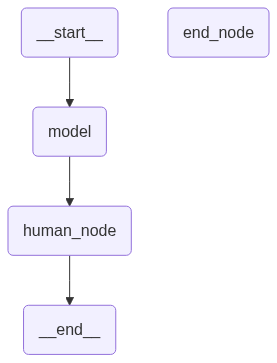

In [122]:
display(Image(data=app.get_graph().draw_mermaid_png()))

In [123]:
linkedin_topic=input("Enter your Linkedin topic: ")
initial_state={
    "linkedin_topic":linkedin_topic,
    "generated_post":[],
    "human_feedback":[]
}

In [124]:
initial_state

{'linkedin_topic': 'Test Cricker', 'generated_post': [], 'human_feedback': []}

In [125]:
for chunk in app.stream(input=initial_state, config=thread_config):
    print(chunk)
    for node_id, value in chunk.items():
        # If we reach an interrupt, continously ask for human feedback
        if (node_id=="__interrupt__"):
            while True:
                user_feedback=input("Provide feedback (or type 'done' when finished): ")

                # Resume the graph execution with the user's feedback
                response=app.invoke(input=Command(resume=user_feedback),config=thread_config)
                print(response)
                # Exit loop if user says done
                if user_feedback.lower()=="done":
                    break

{'model': {'linkedin_topic': 'Test Cricker', 'generated_post': [AIMessage(content='Given that there is no previous feedback, I will create a high-quality LinkedIn post based on the topic "Test Cricket." This post aims to engage the audience, spark discussions, and demonstrate expertise in the field.\n\n**Post Title:** "The Unmatched Excitement of Test Cricket: Why It Remains the Pinnacle of Cricket"\n\n**Introduction**\n\nAs a cricket enthusiast, I\'m often asked why Test cricket remains the most revered and thrilling format of the game. The answer lies in its unique blend of skill, strategy, and endurance. In this post, I\'ll delve into the reasons why Test cricket stands out from the rest and what makes it the ultimate test of a cricketer\'s mettle.\n\n**The Unmatched Challenge**\n\nTest cricket\'s longer duration (five days) and multiple innings present a formidable challenge for players. Each session demands mental and physical toughness, as teams must navigate the ebbs and flows o

In [126]:
persistent_state

{'state': {'linkedin_topic': 'Test Cricker',
  'generated_post': [AIMessage(content='Here\'s a revised LinkedIn post on "Test Cricket" that\'s shorter and engaging:\n\n**The Pride of Test Cricket**\n\nAs a cricket enthusiast, there\'s something special about Test cricket that sets it apart from other formats. The longest, most grueling, and yet, most rewarding form of the game.\n\nFrom the thrill of a century on a difficult pitch to the drama of a drawn Test match, every moment is a testament to the skill, strategy, and endurance of the players.\n\nWhat do you love most about Test cricket? Share your thoughts in the comments below!\n\n#TestCricket #CricketLovers #ThePrideOfTheGame', additional_kwargs={}, response_metadata={}, id='d35c09a2-a426-4ca4-8ca2-8f5446fc4b0e')],
  'human_feedback': [AIMessage(content='Make it ambitious', additional_kwargs={}, response_metadata={}, id='bb893ac9-9721-486f-bdb7-bac77a598a1c'),
   AIMessage(content='make it shorter', additional_kwargs={}, response_